# Installing PySpark

In [2]:
%pip install pyspark==3.1.3

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Libraries Import

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType
# from pyspark.sql.functions import udf

import numpy as np # linear algebra
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Read Files

## For Kaggle 

In [2]:
# INPUT_DIR = '/kaggle/input/walmart-recruiting-store-sales-forecasting'
# FEATURES_PATH = './features.csv'
# STORES_PATH = './stores.csv'
# TEST_PATH = './test.csv'
# TRAIN_PATH = './train.csv'
# SAMPLE_SUBMISSION_PATH = './sampleSubmission.csv'

# !unzip "$INPUT_DIR/*.csv.zip"
# !cp "$INPUT_DIR/stores.csv" "/kaggle/working/"
# !ls

## Local

In [3]:
FEATURES_PATH = r'D:\ME\Project\walmart-recruiting-store-sales-forecasting\features.csv'
STORES_PATH = r'D:\ME\Project\walmart-recruiting-store-sales-forecasting\stores.csv'
TEST_PATH = r'D:\ME\Project\walmart-recruiting-store-sales-forecasting\test.csv'
TRAIN_PATH = r'D:\ME\Project\walmart-recruiting-store-sales-forecasting\train.csv'
SAMPLE_SUBMISSION_PATH = r'D:\ME\Project\walmart-recruiting-store-sales-forecasting\sampleSubmission.csv'

In [4]:
conf = pyspark.SparkConf()

spark = SparkSession \
        .builder \
        .appName("WeeklySales-Forecasting-PySpark") \
        .config(conf=conf) \
        .getOrCreate()

In [5]:
# Load datasets
features_raw = spark.read.option("header",True).csv(FEATURES_PATH)
stores_raw = spark.read.option("header",True).csv(STORES_PATH)
train_raw = spark.read.option("header",True).csv(TRAIN_PATH)
test_raw = spark.read.option("header",True).csv(TEST_PATH)
sample_submission = spark.read.option("header",True).csv(SAMPLE_SUBMISSION_PATH)

# Defining Functions

## Metadata

In [6]:
def get_metadata(dataframe):
    cols = dataframe.columns
    print(" STATISTICAL SUMMARY ".center(125, '#'))
    print()
    dataframe.summary().show()
    print(" SCHEMA OF THE DATASET ".center(125, '#'))
    dataframe.printSchema()
    print(" NULL VALUE COUNTS ".center(125, '#'))
    print()
    dataframe.select([count(when(col(c).isNull(), c)).alias(c) for c in cols]).show()
    dup_count = dataframe.count()-dataframe.distinct().count()
    print(f" Number of duplicate Rows : {dup_count} ".center(125, '='))
    print()
    print(' SAMPLE VALUES IN EVERY COLUMN '.center(125, '#'))
    for c in cols:
        print(c)
        col_list = [data[0] for data in dataframe.select(f'{c}').distinct().orderBy(col(f'{c}')).collect()]
        print('Number of Distinct Values : ', len(col_list))
        print(col_list[:100])
    print(" TYPES OF COLUMNS ".center(125, '#'))
    print()
    print("Categorical Columns : ", [item[0] for item in dataframe.dtypes if item[1].startswith('string')])
    print("Numerical Columns: ", [item[0] for item in dataframe.dtypes if (item[1].startswith('integer') | item[1].startswith('double'))])
    print()
    print(" NEGATIVE-VALUED COLUMNS ".center(125, '#'))
    print()
    sql_expressions = [f'count(CASE WHEN ({col} < 0) THEN 1 END) AS {col}_count' for col in cols]
    dataframe.selectExpr(sql_expressions).show()
    print(''.center(125, '#'))

## Holidays

* Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13 
* Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13 
* Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13 
* Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [7]:
def assign_holiday_names(week):
    if week in ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']:
        return 'SuperBowl Week'
    elif week in ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06']:
        return 'LaborDay Week'
    elif week in ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29']:
        return 'ThanksGiving Week'
    elif week in ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']:
        return 'Christmas'
    else:
        return 'Non-Holiday Week'

In [8]:
# def plot_correlation_matrix(dataframe):
#     vector_col = 'Correlation_Columns'
#     assembler = VectorAssembler(inputCols=dataframe.columns, outputCol=vector_col, handleInvalid = "error")
#     myGraph_vector = assembler.transform(dataframe).select(vector_col)
#     matrix = Correlation.corr(myGraph_vector, vector_col, method='pearson').collect()[0][0]
#     corrmatrix = matrix.toArray().tolist()
#     columns=dataframe.columns
#     fig=plt.figure(figsize=(10,10))
#     ax=fig.add_subplot(111)
#     ax.set_title("Correlation Matrix for Walmart Dataset Features")
#     ax.set_xticklabels(['']+columns)
#     ax.set_yticklabels(['']+columns)
#     cax=ax.matshow(corrmatrix,vmax=1,vmin=-1)
#     fig.colorbar(cax)
#     plt.show()

# EDA

## Features

In [9]:
get_metadata(features_raw)

#################################################### STATISTICAL SUMMARY ####################################################

+-------+---------------+----------+-----------------+-------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+---------+
|summary|          Store|      Date|      Temperature|         Fuel_Price|        MarkDown1|        MarkDown2|         MarkDown3|        MarkDown4|         MarkDown5|               CPI|     Unemployment|IsHoliday|
+-------+---------------+----------+-----------------+-------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+---------+
|  count|           8190|      8190|             8190|               8190|             8190|             8190|              8190|             8190|              8190|              8190|             8190|     8190|
|   mean|        

In [10]:
features_df = features_raw.select(col('Store').cast('int'), \
                                  col('Date').cast('date'), \
                                  col('Temperature').cast('float'), \
                                  col('Fuel_Price').cast('float'), \
                                  col('MarkDown1').cast('float'), \
                                  col('MarkDown2').cast('float'), \
                                  col('MarkDown3').cast('float'), \
                                  col('MarkDown4').cast('float'), \
                                  col('MarkDown5').cast('float'), \
                                  col('CPI').cast('float'), \
                                  col('Unemployment').cast('float'), \
                                  col('IsHoliday'))
features_df

DataFrame[Store: int, Date: date, Temperature: float, Fuel_Price: float, MarkDown1: float, MarkDown2: float, MarkDown3: float, MarkDown4: float, MarkDown5: float, CPI: float, Unemployment: float, IsHoliday: string]

## Stores

In [11]:
get_metadata(stores_raw)

#################################################### STATISTICAL SUMMARY ####################################################

+-------+------------------+----+-----------------+
|summary|             Store|Type|             Size|
+-------+------------------+----+-----------------+
|  count|                45|  45|               45|
|   mean|              23.0|null|         130287.6|
| stddev|13.133925536563698|null|63825.27199115923|
|    min|                 1|   A|           103681|
|    25%|              12.0|null|          70713.0|
|    50%|              23.0|null|         126512.0|
|    75%|              34.0|null|         202307.0|
|    max|                 9|   C|            93638|
+-------+------------------+----+-----------------+

################################################### SCHEMA OF THE DATASET ###################################################
root
 |-- Store: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: string (nullable = true)

#######

In [12]:
stores_df = stores_raw.select(col('Store').cast('int'), \
                              col('Type'), \
                              col('Size').cast('float'))
stores_df

DataFrame[Store: int, Type: string, Size: float]

In [13]:
stores_df.groupBy('Type').agg(min(col('Size')), max(col('Size'))).distinct().orderBy('Type').show()

+----+---------+---------+
|Type|min(Size)|max(Size)|
+----+---------+---------+
|   A|  39690.0| 219622.0|
|   B|  34875.0| 140167.0|
|   C|  39690.0|  42988.0|
+----+---------+---------+



In [14]:
# Check for Missing Stores
print(f'Missing Stores: {train_raw[["Store"]].distinct().count() != features_raw[["Store"]].distinct().count()}')

Missing Stores: False


In [15]:
features_raw[["Store"]].distinct().count()

45

## Train

In [17]:
get_metadata(train_raw)

#################################################### STATISTICAL SUMMARY ####################################################

+-------+------------------+------------------+----------+------------------+---------+
|summary|             Store|              Dept|      Date|      Weekly_Sales|IsHoliday|
+-------+------------------+------------------+----------+------------------+---------+
|  count|            421570|            421570|    421570|            421570|   421570|
|   mean|22.200545579619043| 44.26031738501317|      null|15981.258123467413|     null|
| stddev|12.785297389902782|30.492054015786017|      null| 22711.18351916329|     null|
|    min|                 1|                 1|2010-02-05|             -0.02|    FALSE|
|    25%|              11.0|              18.0|      null|           2079.39|     null|
|    50%|              22.0|              37.0|      null|           7611.48|     null|
|    75%|              33.0|              74.0|      null|           20204.0|    

In [16]:
train_df = train_raw.select(col('Store').cast('int'), col('Dept').cast('int'), col('Date').cast('date'), col('Weekly_Sales').cast('float'), col('IsHoliday'))
train_df

DataFrame[Store: int, Dept: int, Date: date, Weekly_Sales: float, IsHoliday: string]

## Test

In [11]:
get_metadata(test_raw)

#################################################### STATISTICAL SUMMARY ####################################################

+-------+------------------+------------------+----------+---------+
|summary|             Store|              Dept|      Date|IsHoliday|
+-------+------------------+------------------+----------+---------+
|  count|            115064|            115064|    115064|   115064|
|   mean|  22.2382065633039| 44.33952409094069|      null|     null|
| stddev|12.809929591378935|30.656410130030174|      null|     null|
|    min|                 1|                 1|2012-11-02|    FALSE|
|    25%|              11.0|              18.0|      null|     null|
|    50%|              22.0|              37.0|      null|     null|
|    75%|              33.0|              74.0|      null|     null|
|    max|                 9|                99|2013-07-26|     TRUE|
+-------+------------------+------------------+----------+---------+

############################################

In [17]:
test_df = test_raw.select(col('Store').cast('int'), col('Dept').cast('int'), col('Date').cast('date'), col('IsHoliday'))
# test_df.show()

# Pre-processing

## Joining Data

In [18]:
train = train_df.join(stores_df, on=(['Store']), how='inner') \
                .join(features_df, on=(['Store', 'Date', 'IsHoliday']), how='inner')
train.show(3)

+-----+----------+---------+----+------------+----+--------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Type|    Size|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|      CPI|Unemployment|
+-----+----------+---------+----+------------+----+--------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+
|    1|2010-02-05|    FALSE|   1|     24924.5|   A|151315.0|      42.31|     2.572|     null|     null|     null|     null|     null|211.09636|       8.106|
|    1|2010-02-12|     TRUE|   1|    46039.49|   A|151315.0|      38.51|     2.548|     null|     null|     null|     null|     null|211.24217|       8.106|
|    1|2010-02-19|    FALSE|   1|    41595.55|   A|151315.0|      39.93|     2.514|     null|     null|     null|     null|     null|211.28914|       8.106|
+-----+----------+---------+----+------------+----+-------

In [19]:
test = test_df.join(stores_df, on=(['Store']), how='inner') \
                .join(features_df, on=(['Store', 'Date', 'IsHoliday']), how='inner')
# test.show()

## Filling null Values

In [20]:
train_data = train.fillna(0, subset=['Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5'])
# train_data.show()

In [21]:
test_data = test.fillna(0, subset=['Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5'])
# test_data.show()

## Negative Values

In [22]:
train_data.selectExpr([f'count(CASE WHEN ({col} < 0) THEN 1 END) AS {col}_count' for col in train_data.select('Weekly_Sales', 'Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5').columns]).show()

+------------------+---------------+---------------+---------------+---------------+---------------+
|Weekly_Sales_count|Markdown1_count|Markdown2_count|Markdown3_count|Markdown4_count|Markdown5_count|
+------------------+---------------+---------------+---------------+---------------+---------------+
|              1285|              0|           1311|            257|              0|              0|
+------------------+---------------+---------------+---------------+---------------+---------------+



In [23]:
train_data_ = train_data.withColumn('Weekly_Sales', when(col('Weekly_Sales') < 0, 0).otherwise(col('Weekly_Sales'))) \
                        .withColumn('Markdown2', when(col('Markdown2') < 0, 0).otherwise(col('Markdown2'))) \
                        .withColumn('Markdown3', when(col('Markdown3') < 0, 0).otherwise(col('Markdown3'))) 
train_data_.show()

+-----+----------+---------+----+------------+----+--------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Type|    Size|Temperature|Fuel_Price|MarkDown1|Markdown2|Markdown3|MarkDown4|MarkDown5|      CPI|Unemployment|
+-----+----------+---------+----+------------+----+--------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+
|    1|2010-02-05|    FALSE|   1|     24924.5|   A|151315.0|      42.31|     2.572|      0.0|      0.0|      0.0|      0.0|      0.0|211.09636|       8.106|
|    1|2010-02-12|     TRUE|   1|    46039.49|   A|151315.0|      38.51|     2.548|      0.0|      0.0|      0.0|      0.0|      0.0|211.24217|       8.106|
|    1|2010-02-19|    FALSE|   1|    41595.55|   A|151315.0|      39.93|     2.514|      0.0|      0.0|      0.0|      0.0|      0.0|211.28914|       8.106|
|    1|2010-02-26|    FALSE|   1|    19403.54|   A|151315.

In [24]:
train_data_.selectExpr([f'count(CASE WHEN ({col} < 0) THEN 1 END) AS {col}_count' for col in train_data.select('Weekly_Sales', 'Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5').columns]).show()

+------------------+---------------+---------------+---------------+---------------+---------------+
|Weekly_Sales_count|Markdown1_count|Markdown2_count|Markdown3_count|Markdown4_count|Markdown5_count|
+------------------+---------------+---------------+---------------+---------------+---------------+
|                 0|              0|              0|              0|              0|              0|
+------------------+---------------+---------------+---------------+---------------+---------------+



In [25]:
test_data.selectExpr([f'count(CASE WHEN ({col} < 0) THEN 1 END) AS {col}_count' for col in test_data.select('Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5').columns]).show()

+---------------+---------------+---------------+---------------+---------------+
|Markdown1_count|Markdown2_count|Markdown3_count|Markdown4_count|Markdown5_count|
+---------------+---------------+---------------+---------------+---------------+
|            207|            412|            589|              0|            136|
+---------------+---------------+---------------+---------------+---------------+



In [26]:
test_data_ = test_data.withColumn('Markdown1', when(col('Markdown1') < 0, 0).otherwise(col('Markdown1'))) \
                        .withColumn('Markdown2', when(col('Markdown2') < 0, 0).otherwise(col('Markdown2'))) \
                        .withColumn('Markdown3', when(col('Markdown3') < 0, 0).otherwise(col('Markdown3'))) \
                        .withColumn('Markdown5', when(col('Markdown5') < 0, 0).otherwise(col('Markdown5')))

In [27]:
test_data_.selectExpr([f'count(CASE WHEN ({col} < 0) THEN 1 END) AS {col}_count' for col in test_data.select('Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5').columns]).show()

+---------------+---------------+---------------+---------------+---------------+
|Markdown1_count|Markdown2_count|Markdown3_count|Markdown4_count|Markdown5_count|
+---------------+---------------+---------------+---------------+---------------+
|              0|              0|              0|              0|              0|
+---------------+---------------+---------------+---------------+---------------+



## Detecting Outliers

In [28]:
pd_train = train_data_.toPandas()

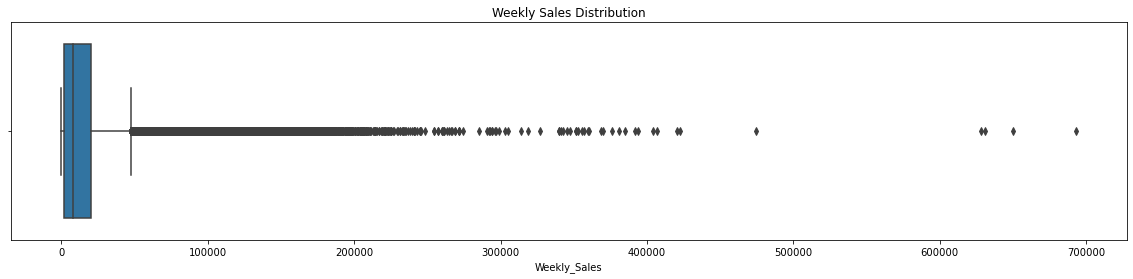

In [29]:
plt.figure(figsize=(20,4))
plt.title('Weekly Sales Distribution')
sns.boxplot(data=pd_train, x='Weekly_Sales')
plt.show()

# Feature Engineering

In [30]:
# HolidayUDF = udf(lambda week: assign_holiday_names(week))

## Holiday References

In [31]:
train_data_f = train_data_.withColumn('Year', year('Date')) \
    .withColumn('Month', month('Date')) \
    .withColumn('Week', weekofyear('Date')) \
    .withColumn('Date_', train_data['Date'].cast('string'))  \
    .withColumn('Holiday_ref', \
        when((col('Date_') == lit('2010-02-12')) | (col('Date_') == lit('2011-02-11')) | (col('Date_') == lit('2012-02-10')) | (col('Date_') == lit('2013-02-08')), 'SuperBowl Week') \
        .when((col('Date_') == lit('2010-09-10')) | (col('Date_') == lit('2011-09-09')) | (col('Date_') == lit('2012-09-07')) | (col('Date_') == lit('2013-09-06')), 'LaborDay Week') \
        .when((col('Date_') == lit('2010-11-26')) | (col('Date_') == lit('2011-11-25')) | (col('Date_') == lit('2012-11-23')) | (col('Date_') == lit('2013-11-29')), 'ThanksGiving Week') \
        .when((col('Date_') == lit('2010-12-31')) | (col('Date_') == lit('2011-12-30')) | (col('Date_') == lit('2012-12-28')) | (col('Date_') == lit('2013-12-27')), 'Christmas Week') \
        .otherwise('Non-Holiday Week'))
train_data_f.show()

+-----+----------+---------+----+------------+----+--------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+----+-----+----+----------+----------------+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Type|    Size|Temperature|Fuel_Price|MarkDown1|Markdown2|Markdown3|MarkDown4|MarkDown5|      CPI|Unemployment|Year|Month|Week|     Date_|     Holiday_ref|
+-----+----------+---------+----+------------+----+--------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+----+-----+----+----------+----------------+
|    1|2010-02-05|    FALSE|   1|     24924.5|   A|151315.0|      42.31|     2.572|      0.0|      0.0|      0.0|      0.0|      0.0|211.09636|       8.106|2010|    2|   5|2010-02-05|Non-Holiday Week|
|    1|2010-02-12|     TRUE|   1|    46039.49|   A|151315.0|      38.51|     2.548|      0.0|      0.0|      0.0|      0.0|      0.0|211.24217|       8.106|2010|    2|   6|2010-02-12|  SuperBowl W

In [32]:
test_data_f = test_data_.withColumn('Year', year('Date')) \
    .withColumn('Month', month('Date')) \
    .withColumn('Week', weekofyear('Date')) \
    .withColumn('Date_', test_data['Date'].cast('string'))  \
    .withColumn('Holiday_ref', \
        when((col('Date_') == lit('2010-02-12')) | (col('Date_') == lit('2011-02-11')) | (col('Date_') == lit('2012-02-10')) | (col('Date_') == lit('2013-02-08')), 'SuperBowl Week') \
        .when((col('Date_') == lit('2010-09-10')) | (col('Date_') == lit('2011-09-09')) | (col('Date_') == lit('2012-09-07')) | (col('Date_') == lit('2013-09-06')), 'LaborDay Week') \
        .when((col('Date_') == lit('2010-11-26')) | (col('Date_') == lit('2011-11-25')) | (col('Date_') == lit('2012-11-23')) | (col('Date_') == lit('2013-11-29')), 'ThanksGiving Week') \
        .when((col('Date_') == lit('2010-12-31')) | (col('Date_') == lit('2011-12-30')) | (col('Date_') == lit('2012-12-28')) | (col('Date_') == lit('2013-12-27')), 'Christmas Week') \
        .otherwise('Non-Holiday Week'))
test_data_f.show()

+-----+----------+---------+----+----+--------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+----+-----+----+----------+-----------------+
|Store|      Date|IsHoliday|Dept|Type|    Size|Temperature|Fuel_Price|Markdown1|Markdown2|Markdown3|MarkDown4|Markdown5|      CPI|Unemployment|Year|Month|Week|     Date_|      Holiday_ref|
+-----+----------+---------+----+----+--------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+----+-----+----+----------+-----------------+
|    1|2012-11-02|    FALSE|   1|   A|151315.0|      55.32|     3.386|  6766.44|   5147.7|    50.82|   3639.9|  2737.42|223.46278|       6.573|2012|   11|  44|2012-11-02| Non-Holiday Week|
|    1|2012-11-09|    FALSE|   1|   A|151315.0|      61.24|     3.314| 11421.32|  3370.89|    40.28|  4646.79|  6154.16|223.48131|       6.573|2012|   11|  45|2012-11-09| Non-Holiday Week|
|    1|2012-11-16|    FALSE|   1|   A|151315.0|      52

## Markdown

In [33]:
train_data_md = train_data_f.withColumn('Markdown', (col('Markdown1')+col('Markdown2')+col('Markdown3')+col('Markdown4')+col('Markdown5'))/5) \
    .drop('Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5')
train_data_md.show()

+-----+----------+---------+----+------------+----+--------+-----------+----------+---------+------------+----+-----+----+----------+----------------+--------+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Type|    Size|Temperature|Fuel_Price|      CPI|Unemployment|Year|Month|Week|     Date_|     Holiday_ref|Markdown|
+-----+----------+---------+----+------------+----+--------+-----------+----------+---------+------------+----+-----+----+----------+----------------+--------+
|    1|2010-02-05|    FALSE|   1|     24924.5|   A|151315.0|      42.31|     2.572|211.09636|       8.106|2010|    2|   5|2010-02-05|Non-Holiday Week|     0.0|
|    1|2010-02-12|     TRUE|   1|    46039.49|   A|151315.0|      38.51|     2.548|211.24217|       8.106|2010|    2|   6|2010-02-12|  SuperBowl Week|     0.0|
|    1|2010-02-19|    FALSE|   1|    41595.55|   A|151315.0|      39.93|     2.514|211.28914|       8.106|2010|    2|   7|2010-02-19|Non-Holiday Week|     0.0|
|    1|2010-02-26|    FALSE|   1|    194

In [34]:
test_data_md = test_data_f.withColumn('Markdown', (col('Markdown1')+col('Markdown2')+col('Markdown3')+col('Markdown4')+col('Markdown5'))/5) \
    .drop('Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5')
test_data_md.show(2)

+-----+----------+---------+----+----+--------+-----------+----------+---------+------------+----+-----+----+----------+----------------+-------------+
|Store|      Date|IsHoliday|Dept|Type|    Size|Temperature|Fuel_Price|      CPI|Unemployment|Year|Month|Week|     Date_|     Holiday_ref|     Markdown|
+-----+----------+---------+----+----+--------+-----------+----------+---------+------------+----+-----+----+----------+----------------+-------------+
|    1|2012-11-02|    FALSE|   1|   A|151315.0|      55.32|     3.386|223.46278|       6.573|2012|   11|  44|2012-11-02|Non-Holiday Week|   3668.45625|
|    1|2012-11-09|    FALSE|   1|   A|151315.0|      61.24|     3.314|223.48131|       6.573|2012|   11|  45|2012-11-09|Non-Holiday Week|5126.68828125|
+-----+----------+---------+----+----+--------+-----------+----------+---------+------------+----+-----+----+----------+----------------+-------------+
only showing top 2 rows



## Dropping Unnecessary Columns

In [35]:
train_pp = train_data_md.drop('Date', 'IsHoliday', 'Type', 'Date_')
test_pp = test_data_md.drop('Date', 'IsHoliday', 'Type', 'Date_')

In [36]:
train_pp.show(2)

+-----+----+------------+--------+-----------+----------+---------+------------+----+-----+----+----------------+--------+
|Store|Dept|Weekly_Sales|    Size|Temperature|Fuel_Price|      CPI|Unemployment|Year|Month|Week|     Holiday_ref|Markdown|
+-----+----+------------+--------+-----------+----------+---------+------------+----+-----+----+----------------+--------+
|    1|   1|     24924.5|151315.0|      42.31|     2.572|211.09636|       8.106|2010|    2|   5|Non-Holiday Week|     0.0|
|    1|   1|    46039.49|151315.0|      38.51|     2.548|211.24217|       8.106|2010|    2|   6|  SuperBowl Week|     0.0|
+-----+----+------------+--------+-----------+----------+---------+------------+----+-----+----+----------------+--------+
only showing top 2 rows



## Plots

In [37]:
pd_train = train_pp.toPandas()

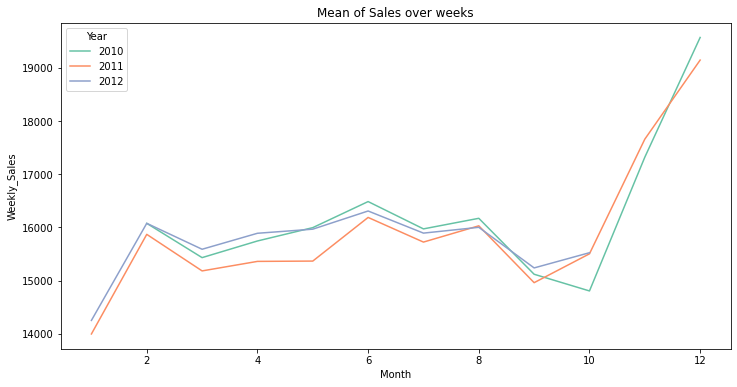

In [38]:
plt.figure(figsize=(12,6))
plt.title('Mean of Sales over weeks')
sns.lineplot(data=pd_train, x='Month', y='Weekly_Sales', hue='Year', estimator='mean', ci=None, palette='Set2')
plt.show()

Average Sales is higher in November and December during all the years(2010, 2011, 2012)

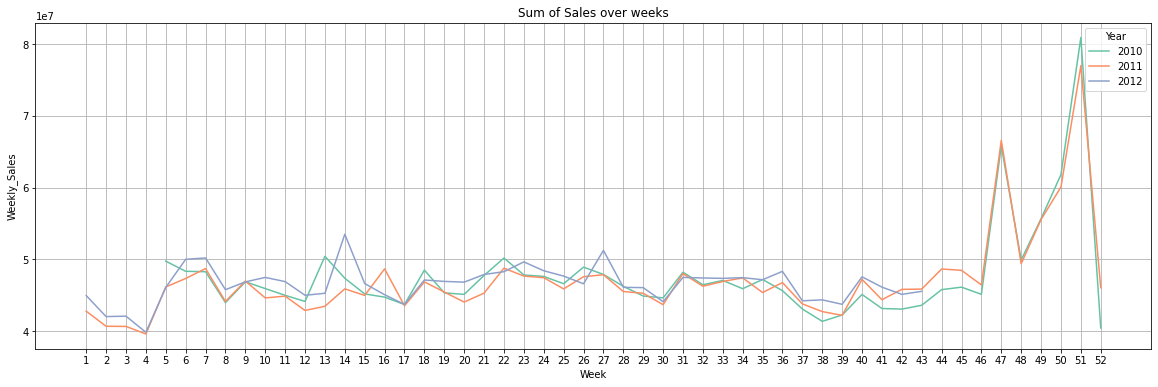

In [39]:
plt.figure(figsize=(20,6))
plt.title('Sum of Sales over weeks')
sns.lineplot(data=pd_train, x='Week', y='Weekly_Sales', hue='Year', estimator='sum', ci=None, palette='Set2')
plt.xticks(np.arange(1,53))
plt.grid()
plt.show()

47th Week and 51st Week show Higher Sales(Drastic Peak)

In [40]:
train_pp.filter(col('Holiday_ref')!='Non-Holiday Week').select('Week', 'Holiday_ref').distinct().orderBy('Week').show()

+----+-----------------+
|Week|      Holiday_ref|
+----+-----------------+
|   6|   SuperBowl Week|
|  36|    LaborDay Week|
|  47|ThanksGiving Week|
|  52|   Christmas Week|
+----+-----------------+



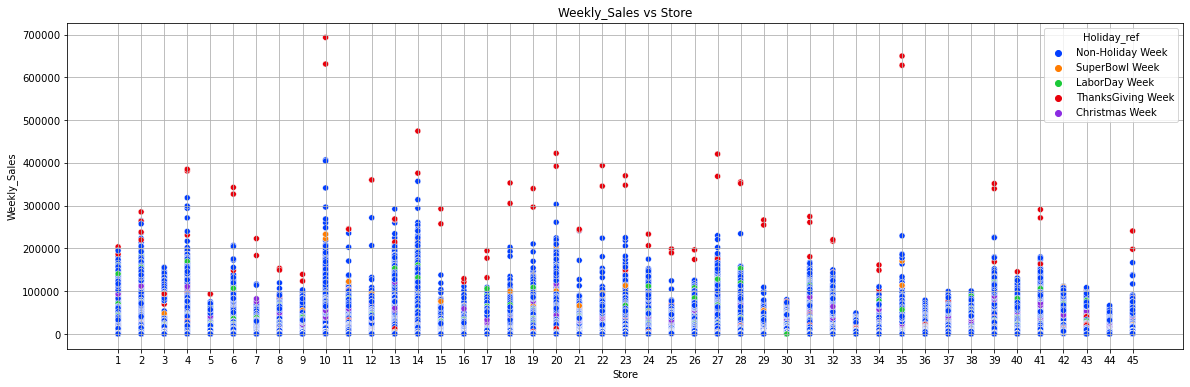

In [41]:
plt.figure(figsize=(20,6))
plt.title('Weekly_Sales vs Store')
# sns.set(style='whitegrid')
sns.scatterplot(x='Store', y='Weekly_Sales', hue='Holiday_ref', data=pd_train, palette='bright') # Weekly_Sales -> 0.3 =30L
plt.xticks(np.arange(1,46))
plt.grid()
plt.show()

Inferences:
* The Sales are higher during ThanksGiving Week in most of the Store 
* Store 33 has very Negligibly Very Low Sale

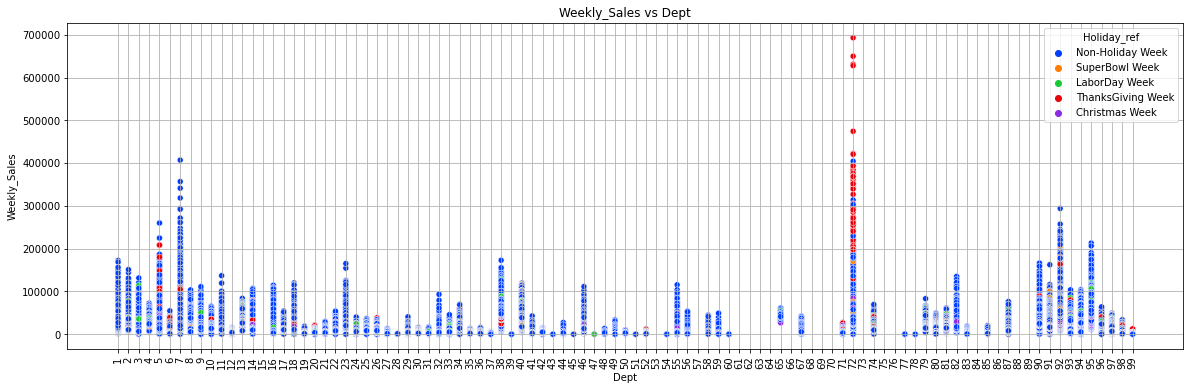

In [42]:
plt.figure(figsize=(20,6))
plt.title('Weekly_Sales vs Dept')
# sns.set(style='whitegrid')
sns.scatterplot(x='Dept', y='Weekly_Sales', hue='Holiday_ref', data=pd_train, palette='bright') # Weekly_Sales -> 0.3 =30L
plt.xticks(np.arange(1,100), rotation=90)
plt.grid()
plt.show()

Inferences:  
* Dept 72 has the most Sales 
* Dept 7 has most Sales during Non-Holiday Week
* Dept 15, 53, 61, 62, 63, 64, 68, 69, 70, 75, 76, 84, 88 and 89 has NO SALES

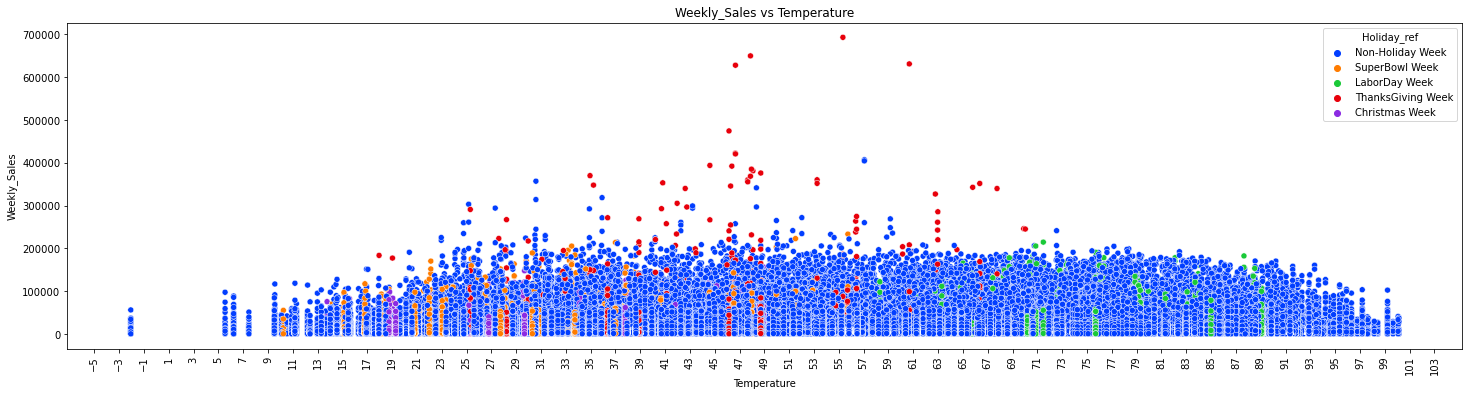

In [43]:
plt.figure(figsize=(25,6))
plt.title('Weekly_Sales vs Temperature')
# sns.set(style='whitegrid')
sns.scatterplot(x='Temperature', y='Weekly_Sales', hue='Holiday_ref', data=pd_train, palette='bright') # Weekly_Sales -> 0.3 =30L
plt.xticks(np.arange(-5,105, step=2), rotation=90)
plt.show()

Inferences: 
* There are Sales when Temperature is -2degree Celsius
* Sales drop when the Temperature is Low(between -5degree and +20degree) and High(> +95degrees)

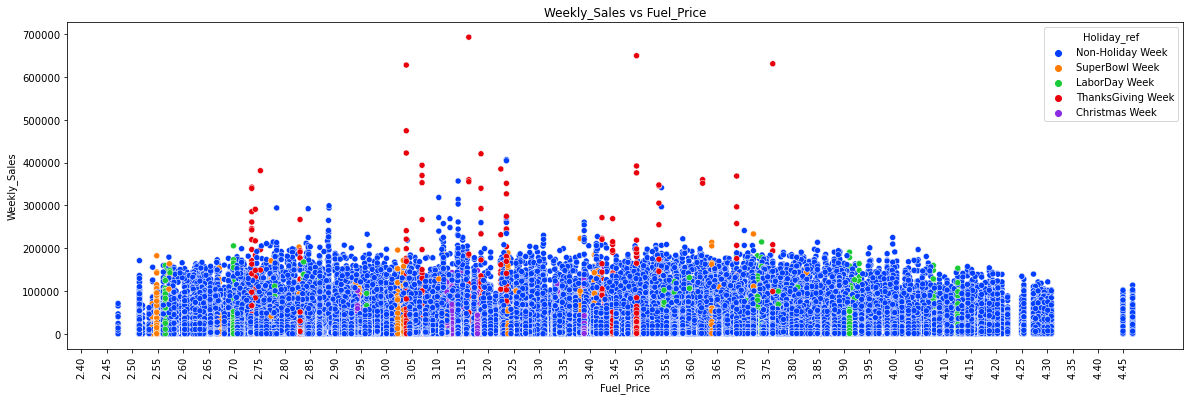

In [44]:
plt.figure(figsize=(20,6))
plt.title('Weekly_Sales vs Fuel_Price')
# sns.set(style='whitegrid')
sns.scatterplot(x='Fuel_Price', y='Weekly_Sales', hue='Holiday_ref', data=pd_train, palette='bright') # Weekly_Sales -> 0.3 =30L
plt.xticks(np.arange(2.4,4.5, step=0.05), rotation=90)
plt.show()

Inference:
* When Fuel Price is higher than 4.20, the Sales are Lesser

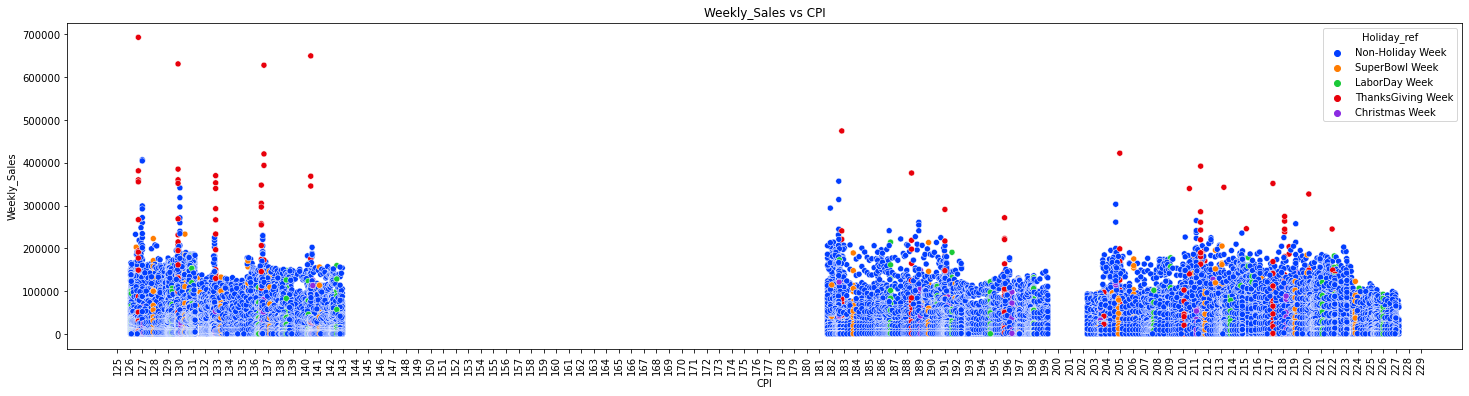

In [45]:
plt.figure(figsize=(25,6))
plt.title('Weekly_Sales vs CPI')
# sns.set(style='whitegrid')
sns.scatterplot(x='CPI', y='Weekly_Sales', hue='Holiday_ref', data=pd_train, palette='bright') # Weekly_Sales -> 0.3 =30L
plt.xticks(np.arange(125,230, step=1), rotation=90)
plt.show()

Inference:
* Even if the CPI is higher, the Sales are more - CPI does not affect the Sales

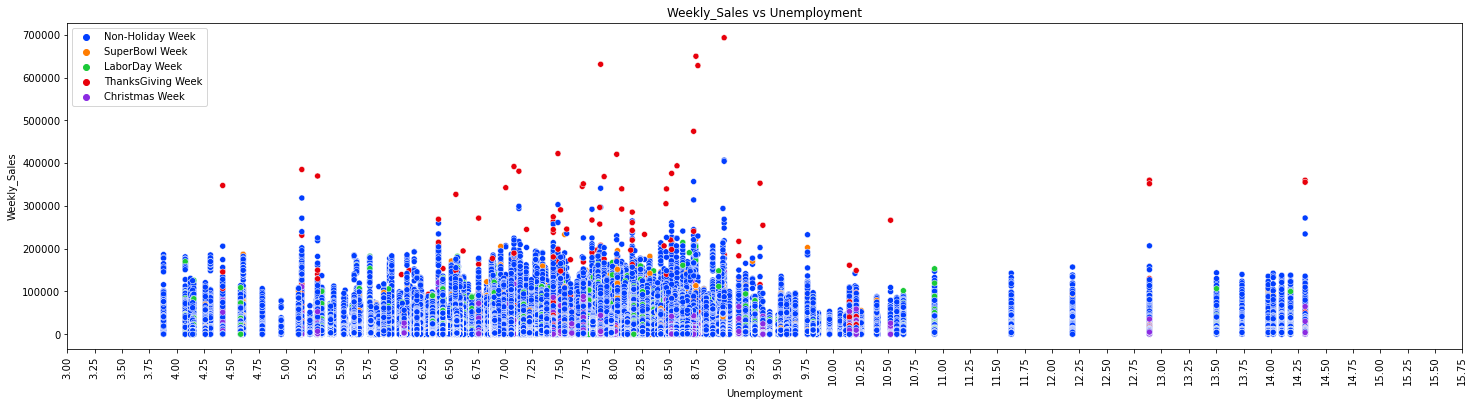

In [46]:
plt.figure(figsize=(25,6))
plt.title('Weekly_Sales vs Unemployment')
# sns.set(style='whitegrid')
sns.scatterplot(x='Unemployment', y='Weekly_Sales', hue='Holiday_ref', data=pd_train, palette='bright') # Weekly_Sales -> 0.3 =30L
plt.legend(loc='upper left')
plt.xticks(np.arange(3,16, step=0.25), rotation=90)
plt.show()

Inference:
* More the Unemployment Rate, Lesser is the Sales

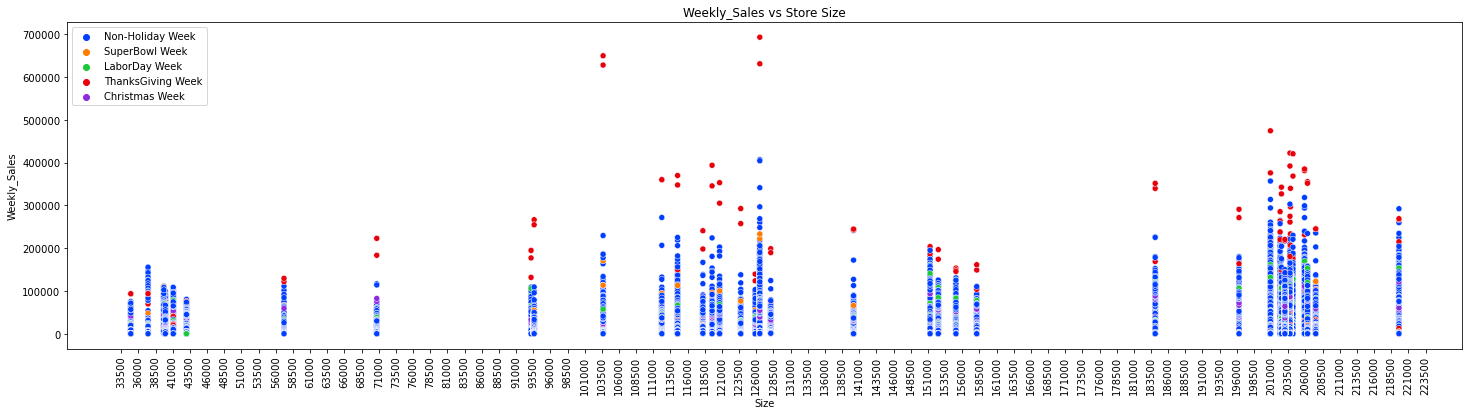

In [47]:
plt.figure(figsize=(25,6))
plt.title('Weekly_Sales vs Store Size')
# sns.set(style='whitegrid')
sns.scatterplot(x='Size', y='Weekly_Sales', hue='Holiday_ref', data=pd_train, palette='bright') # Weekly_Sales -> 0.3 =30L
plt.legend(loc='upper left')
plt.xticks(np.arange(33500,225000, step=2500), rotation=90)
plt.show()

Inference:
* Lower the Store Size, lower is the Sales when compared with higher Size Stores

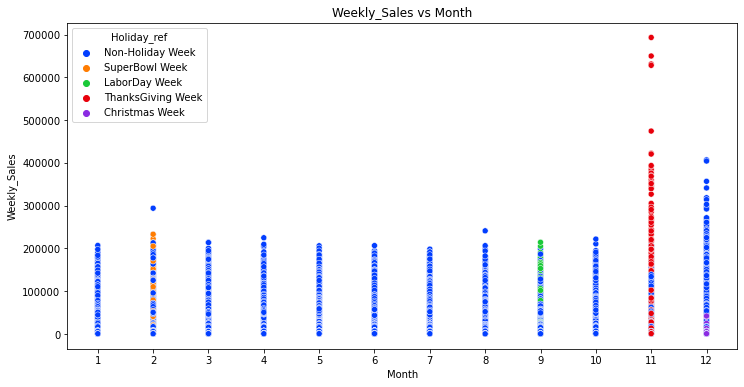

In [48]:
plt.figure(figsize=(12,6))
plt.title('Weekly_Sales vs Month')
# sns.set(style='whitegrid')
sns.scatterplot(x='Month', y='Weekly_Sales', hue='Holiday_ref', data=pd_train, palette='bright') # Weekly_Sales -> 0.3 =30L
plt.xticks(np.arange(1,13))
plt.show()

Inference:
* Sales is Higher during Nov and Dec

## Encoding

In [49]:
train_pp.show(2)

+-----+----+------------+--------+-----------+----------+---------+------------+----+-----+----+----------------+--------+
|Store|Dept|Weekly_Sales|    Size|Temperature|Fuel_Price|      CPI|Unemployment|Year|Month|Week|     Holiday_ref|Markdown|
+-----+----+------------+--------+-----------+----------+---------+------------+----+-----+----+----------------+--------+
|    1|   1|     24924.5|151315.0|      42.31|     2.572|211.09636|       8.106|2010|    2|   5|Non-Holiday Week|     0.0|
|    1|   1|    46039.49|151315.0|      38.51|     2.548|211.24217|       8.106|2010|    2|   6|  SuperBowl Week|     0.0|
+-----+----+------------+--------+-----------+----------+---------+------------+----+-----+----+----------------+--------+
only showing top 2 rows



In [50]:
holiday = train_pp.select("Store").distinct().rdd.flatMap(lambda x: x).collect()
holiday.take(2)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 43 in stage 166.0 failed 1 times, most recent failure: Lost task 43.0 in stage 166.0 (TID 9644) (Riddhi-Lappy executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:498)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:501)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 14 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2303)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2252)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2251)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2251)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1124)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2490)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2432)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2421)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:902)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2261)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:498)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:501)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 14 more


In [ ]:
types_expr = [when(col("TYPE") == ty, 1).otherwise(0).alias("e_TYPE_" + ty) for ty in types]

In [74]:
indexer = StringIndexer(inputCols=['Holiday_ref'], outputCols=['Holiday_Week_Index'])
indexer_fitted = indexer.fit(train_pp)
df_indexed = indexer_fitted.transform(train_pp)

encoder = OneHotEncoder(inputCols=['Holiday_Week_Index'], outputCols=['Holiday_Week_Ref'], dropLast=False)
train_encoded = encoder.fit(df_indexed).transform(df_indexed) \
                            .drop('Holiday_ref', 'Holiday_Week_Index') 
                            # .withColumnRenamed('Type_OH', 'Type')
train_encoded.show(3)

+-----+----+------------+--------+-----------+----------+---------+------------+----+-----+----+--------+----------------+
|Store|Dept|Weekly_Sales|    Size|Temperature|Fuel_Price|      CPI|Unemployment|Year|Month|Week|Markdown|Holiday_Week_Ref|
+-----+----+------------+--------+-----------+----------+---------+------------+----+-----+----+--------+----------------+
|    1|   1|     24924.5|151315.0|      42.31|     2.572|211.09636|       8.106|2010|    2|   5|     0.0|   (5,[0],[1.0])|
|    1|   1|    46039.49|151315.0|      38.51|     2.548|211.24217|       8.106|2010|    2|   6|     0.0|   (5,[1],[1.0])|
|    1|   1|    41595.55|151315.0|      39.93|     2.514|211.28914|       8.106|2010|    2|   7|     0.0|   (5,[0],[1.0])|
+-----+----+------------+--------+-----------+----------+---------+------------+----+-----+----+--------+----------------+
only showing top 3 rows

